# Tirer pleinement parti de votre abonnement à Colab



In [1]:
!pip install supervisely

In [2]:
import supervisely as sly
import numpy as np
import os
from tqdm import tqdm
import imutils
from imutils import paths
import cv2
import matplotlib.pyplot as plt
import gc

In [3]:
# key account
key = "fkPb1EFum5BIDfKPYnuFiW6QPxXM0POif5vYM9JDE3FNfoAFCE0sXZoWiHpHAzt70wfFC39EKfLQtYFGklhb4f2XB1VioxLJ7CiaAyMeEQdYWgg3XRg0A5sEOLneM6sD"
api = sly.Api(server_address="https://app.supervise.ly", token=key)

In [4]:
project_id = 265377

save_directory = "autofocus_dataset"
os.makedirs(save_directory)
# Download Project
sly.Project.download(api, project_id, save_directory)
project_fs = sly.Project(save_directory, sly.OpenMode.READ)
dataset_path = os.path.join(os.getcwd(), save_directory, "ds0")
ds = sly.Dataset(dataset_path, sly.OpenMode.READ)
ds.get_classes_stats()

{'items_count': {}, 'objects_count': {}, 'figures_count': {}}

In [9]:
import argparse
from typing import Optional

import albumentations as A
import numpy as np
import torch
import torchvision
from matplotlib import pyplot as plt
from torch import nn
from torch.nn import Linear, Hardswish, Dropout
from torch.utils.data import DataLoader
from MicroscopeAutofocus.autofocus.autofocus_dataset import AutofocusDataset

In [7]:
!git clone https://github.com/tcotte/MicroscopeAutofocus.git

Cloning into 'MicroscopeAutofocus'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 27 (delta 3), reused 24 (delta 3), pack-reused 0
Receiving objects: 100% (27/27), 5.58 MiB | 14.78 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [10]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.8/218.8 kB 20.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=ca562b22b7ccb60583a22a7979cb3fe1ae7872ad01a2acbdf36fbf8d151ebc48
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [14]:
import platform

def get_os() -> str:
    return platform.system()

In [25]:
%reload_ext autoreload

%autoreload 2

In [31]:
import os

import albumentations as A
import albumentations.pytorch
import imutils.paths
import numpy as np
import supervisely as sly
from PIL import Image
from torch.utils.data import Dataset
from torchvision.transforms import transforms
import numpy as np

class AutofocusDataset(Dataset):
    def __init__(self, project_dir: str, dataset: str, z_range = [-np.inf, np.inf], transform=None):
        self.transform = transform

        self.project = sly.Project(project_dir, sly.OpenMode.READ)
        self.meta = self.project.meta
        self.dataset = self.project.datasets.get(dataset)

        self.z_range = z_range
        self.images_paths = self.filter_dataset()

        self.img_dir = self.dataset.img_dir
        self.label_dir = self.dataset.ann_dir

    def __len__(self):
        return len(self.images_paths)

    def filter_dataset(self):
        filtered_images = []
        for item in self.dataset.items():
            item_name, picture_path, json_path = item
            annotation = sly.Annotation.load_json_file(json_path, self.meta)
            z_value = annotation.img_tags.get('focus_difference').value
            if z_value >= self.z_range[0] and z_value <= self.z_range[1]:
                filtered_images.append(picture_path)

        return filtered_images


    def __getitem__(self, idx):
        img_path = self.images_paths[idx]

        head, tail = os.path.split(img_path)
        annotation = sly.Annotation.load_json_file(os.path.join(self.label_dir, tail + ".json"), self.meta)
        z_value = annotation.img_tags.get('focus_difference').value

        pillow_image = Image.open(img_path)

        if self.transform is None:
            transform = transforms.ToTensor()

            # Convert the image to PyTorch tensor
            tensor_image = transform(pillow_image)

        else:
            transformed = self.transform(image=np.array(pillow_image))
            tensor_image = transformed["image"]

        return {"X": tensor_image, "y": z_value}

In [39]:
train_dataset = AutofocusDataset(
    project_dir="autofocus_dataset",
    dataset="ds0", z_range=[-145, 150], transform=train_transform)
len(train_dataset)

2220

In [38]:
2176/128

17.0

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


[1,     1] loss: 74.479  -- MSE: 7478.6787109375
[1,     3] loss: 66.039  -- MSE: 19859.259765625
[1,     5] loss: 62.401  -- MSE: 31390.990234375
[1,     7] loss: 67.353  -- MSE: 43216.3359375
[1,     9] loss: 67.758  -- MSE: 55520.734375
[1,    11] loss: 67.602  -- MSE: 67318.765625
[1,    13] loss: 71.812  -- MSE: 80520.328125
[1,    15] loss: 67.495  -- MSE: 92475.7734375
[1,    17] loss: 66.502  -- MSE: 104565.8515625
Epoch 1: train_loss 1196.2161598205566 -- test_loss 368.14200592041016 -- train_accuracy 6192.558159722223 -- test_accuracy 1413.76357421875
[2,     1] loss: 61.406  -- MSE: 5457.46044921875
[2,     3] loss: 66.811  -- MSE: 17753.45703125
[2,     5] loss: 57.114  -- MSE: 28651.216796875
[2,     7] loss: 69.481  -- MSE: 40875.4453125
[2,     9] loss: 62.915  -- MSE: 51703.61328125
[2,    11] loss: 64.855  -- MSE: 64009.0390625
[2,    13] loss: 60.929  -- MSE: 76072.140625
[2,    15] loss: 70.960  -- MSE: 89794.0
[2,    17] loss: 62.352  -- MSE: 100998.59375
Epoch 2: t

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ba88fd34160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ba88fd34160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

[90,     9] loss: 2.806  -- MSE: 717.810791015625
[90,    11] loss: 7.935  -- MSE: 950.4249267578125
[90,    13] loss: 3.444  -- MSE: 1087.3692626953125
[90,    15] loss: 18.430  -- MSE: 1550.561767578125
[90,    17] loss: 5.931  -- MSE: 1646.7349853515625
Epoch 90: train_loss 120.87315464019775 -- test_loss 147.37842559814453 -- train_accuracy 98.81644694010417 -- test_accuracy 330.2297119140625
[91,     1] loss: 8.919  -- MSE: 118.39698028564453
[91,     3] loss: 10.918  -- MSE: 513.815673828125
[91,     5] loss: 8.691  -- MSE: 709.4097900390625
[91,     7] loss: 3.177  -- MSE: 772.002685546875
[91,     9] loss: 4.780  -- MSE: 853.0516357421875
[91,    11] loss: 8.521  -- MSE: 997.6154174804688
[91,    13] loss: 3.738  -- MSE: 1091.9456787109375
[91,    15] loss: 4.024  -- MSE: 1162.4866943359375
[91,    17] loss: 3.993  -- MSE: 1276.1153564453125
Epoch 91: train_loss 110.23679399490356 -- test_loss 150.25450706481934 -- train_accuracy 73.98305257161458 -- test_accuracy 253.571337890

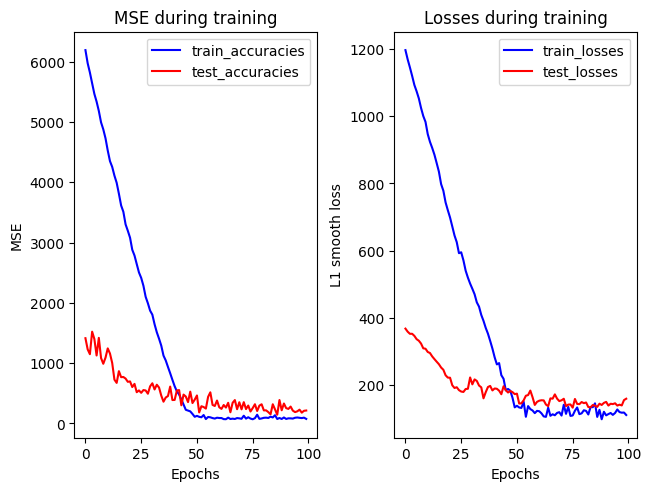

In [40]:
from MicroscopeAutofocus.autofocus.logger import WeightandBiaises


PROJECT_NAME = "Microscope_autofocus"
RUN_NAME = "Run_complex_model_filtered_ds"

BATCH_SIZE = 128
LEARNING_RATE = 0.0001
NB_EPOCHS = 100
DROPOUT = 0.3
WEIGHT_DECAY = 1e-4



### Datasets

# Augmentations
train_transform = A.Compose([
    A.Normalize(),
    A.augmentations.geometric.resize.LongestMaxSize(max_size=512),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.augmentations.transforms.PixelDropout (dropout_prob=0.01),
    A.RandomBrightnessContrast(p=0.2),
    A.pytorch.transforms.ToTensorV2(),
])

test_transform = A.Compose([
    A.Normalize(),
    A.augmentations.geometric.resize.LongestMaxSize(max_size=512),
    A.pytorch.transforms.ToTensorV2()
])

# Pytorch datasets
train_dataset = AutofocusDataset(
    project_dir="autofocus_dataset",
    dataset="ds0", z_range=[-145, 150], transform=train_transform)
test_dataset = AutofocusDataset(
    project_dir="autofocus_dataset",
    dataset="ds1", z_range=[-145, 150], transform=test_transform)

# Dataloaders

if get_os().lower() == "windows":
    num_workers = 0
else:
    num_workers = os.cpu_count()

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True,
                             num_workers=num_workers)

### Model

pretrained_weights = True
if pretrained_weights:
    model = torchvision.models.mobilenet_v3_small(weights='DEFAULT', dropout=DROPOUT)
else:
    model = torchvision.models.mobilenet_v3_small(dropout= DROPOUT)

"""
https://medium.com/analytics-vidhya/fastai-image-regression-age-prediction-based-on-image-68294d34f2ed
"""
layers = []
layers += [Linear(in_features=576, out_features=1024)]
layers += [nn.BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
layers += [nn.Dropout(p=DROPOUT)]
layers += [nn.Linear(1024, 512, bias=True), nn.ReLU(inplace=True)]
layers += [nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
layers += [nn.Dropout(p=DROPOUT)]
layers += [nn.Linear(512, 16, bias=True), nn.ReLU(inplace=True)]
layers += [nn.Linear(16,1)]
model.classifier = nn.Sequential(*layers)

criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

### Training
w_b = WeightandBiaises(project_name=PROJECT_NAME, run_id=RUN_NAME)

nb_train_batch = np.ceil(len(train_dataset) / BATCH_SIZE)
nb_test_batch = np.ceil(len(test_dataset) / BATCH_SIZE)

mse_func = nn.MSELoss(reduction="mean")

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

model.to(device)

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(NB_EPOCHS):  # loop over the dataset multiple times
    train_running_loss = 0.0
    test_running_loss = 0.0
    train_mse = 0.0
    test_mse = 0.0

    model.train()
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        images, labels = data["X"].float(), data["y"]

        images = images.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(images)
        train_loss = criterion(outputs.squeeze(), labels)
        train_loss.backward()
        optimizer.step()

        train_mse += mse_func(outputs.squeeze(), labels)

        # print statistics
        train_running_loss += train_loss.item()
        if i % 2 == 0:  # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {train_loss.item():.3f}  -- MSE: {train_mse}')

    model.eval()
    with torch.no_grad():
        for data in test_dataloader:
            images, labels = data["X"].float(), data["y"]

            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)

            test_mse = mse_func(outputs.squeeze(), labels)
            test_loss = criterion(outputs.squeeze(), labels)

            test_running_loss += test_loss.item()

    w_b.log_accuracy(accuracy=test_mse, epoch=epoch)
    w_b.log_losses(train_loss=train_running_loss, test_loss=test_running_loss, epoch=epoch)

    print(f"Epoch {str(epoch + 1)}: train_loss {train_running_loss} -- test_loss {test_running_loss} -- "
          f"train_accuracy {train_mse.item() / nb_train_batch} -- test_accuracy {test_mse.item() / nb_test_batch}")

    train_losses.append(train_running_loss)
    test_losses.append(test_running_loss)
    train_accuracies.append(train_mse.item() / nb_train_batch)
    test_accuracies.append(test_mse.item() / nb_test_batch)

torch.save(model.state_dict(), RUN_NAME +".pt")

# Plot training data

t = list(range(NB_EPOCHS))
_, axs = plt.subplots(1, 2, layout='constrained')
axs[0].plot(t, train_accuracies, 'b', label="train_accuracies")  # plotting t, a separately
axs[0].plot(t, test_accuracies, 'r', label="test_accuracies")
axs[0].set_title("MSE during training")
axs[0].set_ylabel("MSE")
axs[0].set_xlabel("Epochs")
axs[0].legend()

axs[1].plot(t, train_losses, 'b', label="train_losses")  # plotting t, a separately
axs[1].plot(t, test_losses, 'r', label="test_losses")
axs[1].set_title("Losses during training")
axs[1].set_ylabel("L1 smooth loss")
axs[1].set_xlabel("Epochs")
axs[1].legend()

plt.show()

### Inferences

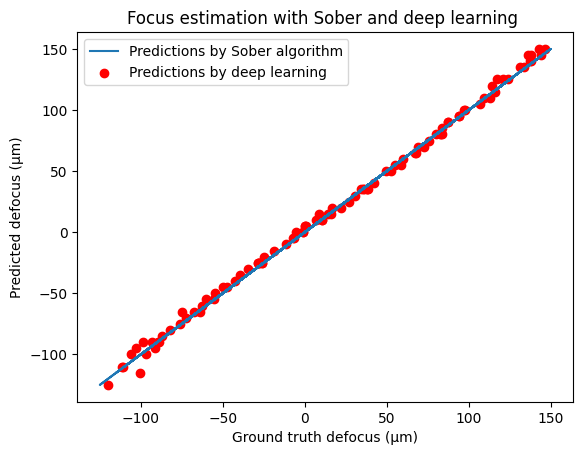

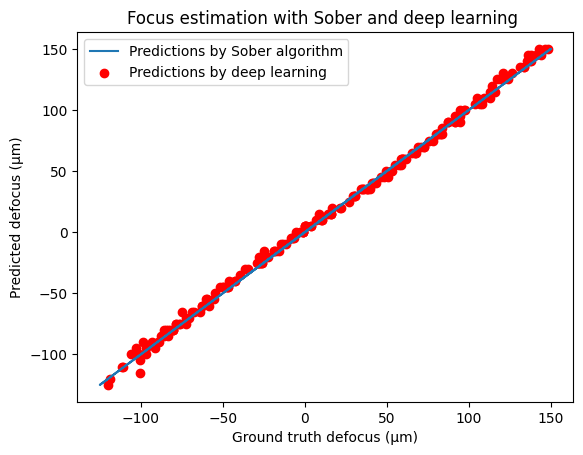

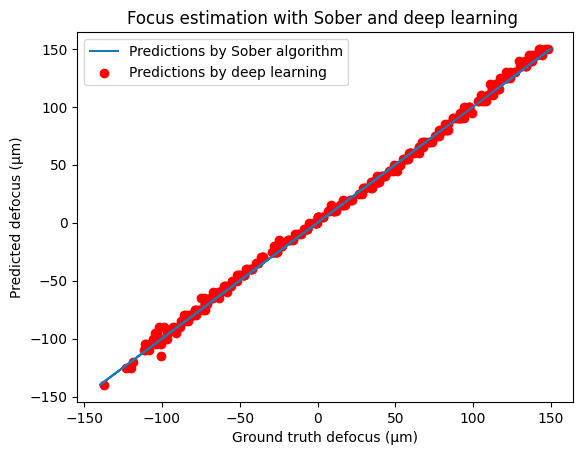

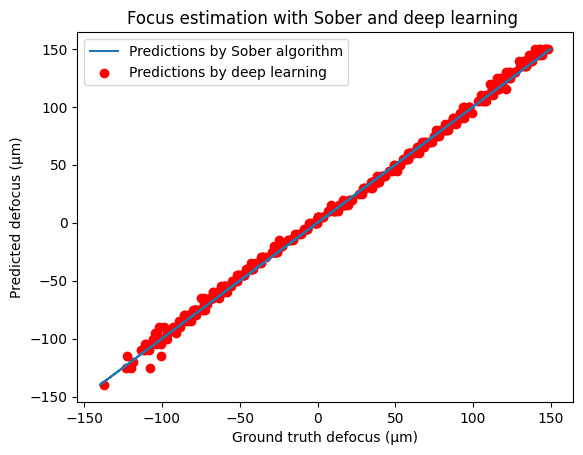

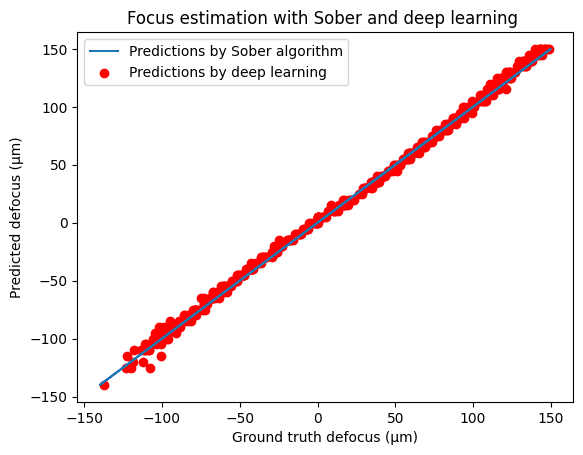

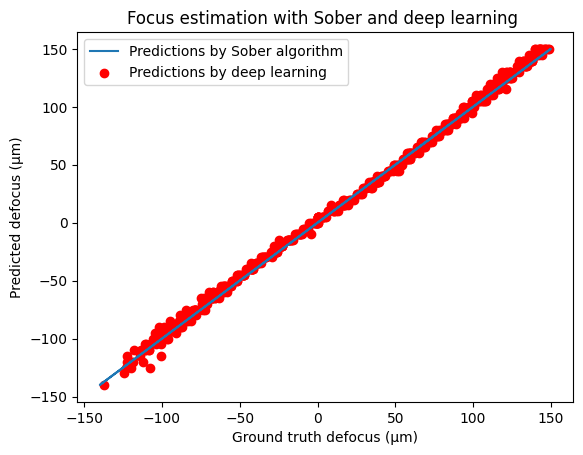

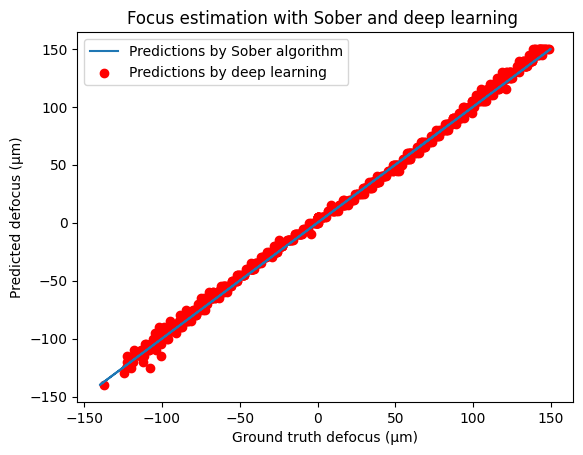

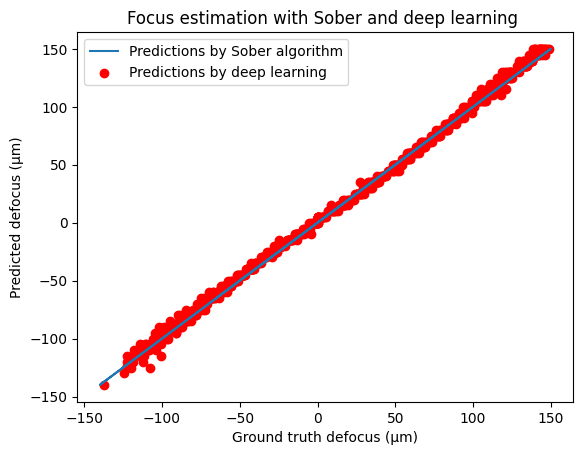

In [46]:
test_dataset = AutofocusDataset(
    project_dir=r"/content/autofocus_dataset",
    dataset="ds2", transform=test_transform)

model = torchvision.models.mobilenet_v3_small()
layers = []
layers += [Linear(in_features=576, out_features=1024)]
layers += [nn.BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
layers += [nn.Dropout(p=DROPOUT)]
layers += [nn.Linear(1024, 512, bias=True), nn.ReLU(inplace=True)]
layers += [nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
layers += [nn.Dropout(p=DROPOUT)]
layers += [nn.Linear(512, 16, bias=True), nn.ReLU(inplace=True)]
layers += [nn.Linear(16,1)]
model.classifier = nn.Sequential(*layers)

model.load_state_dict(torch.load("/content/Run_complex_model_filtered_ds.pt"))
model.to(device)
model.eval()


y = []
y_hat = []

with torch.no_grad():
  for i in range(8):
    for idx in range(0 + i*100, 100+ i * 100):
        data = torch.unsqueeze(train_dataset[idx]["X"].float(), dim=0)
        data = data.to(device)
        y_hat.append(model(data).cpu().item())
        y.append(train_dataset[idx]["y"])

    plt.plot(y, y, label="Predictions by Sober algorithm")
    plt.ylabel("Predicted defocus (µm)")
    plt.xlabel("Ground truth defocus (µm)")

    plt.scatter(y_hat, y, c='r', label="Predictions by deep learning")
    plt.legend()
    plt.title("Focus estimation with Sober and deep learning ")
    plt.show()